In [1]:
from ultralytics import YOLO  # Add import for YOLOv8
import cv2
import numpy as np

c:\Users\romy.bouabdo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# pip install ultralytics

# DataSet

In [2]:
model_path = 'yolov8n.pt'

# YOLO

In [16]:
class ObjectDetector:
    def __init__(self, model_path):
        """Initialize the YOLOv8 object detector."""
        self.model = YOLO(model_path)  # Load YOLOv8 model

    def detect_objects(self, image_path):
        """Run YOLOv8n object detection on a single image."""
        # Read the image
        frame = cv2.imread(image_path)
        if frame is None:
            raise ValueError("Failed to load image. Check the file path.")
        
        # Resize image to a fixed size
        frame = cv2.resize(frame, (640, 640))

        # Run YOLOv8 inference on the frame
        results = self.model(frame)

        # Process results
        detected_frame = results[0].plot()  # Get the annotated frame
        detections = []

        # Extract detection information
        object_centers = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get box coordinates
                conf = float(box.conf[0])              # Get confidence score
                cls = int(box.cls[0])                  # Get class id
                name = result.names[cls]               # Get class name
                
                # Calculate object center
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)
                object_centers.append((center_x, center_y))

                detections.append({
                    'class': name,
                    'confidence': conf,
                    'bbox': [x1, y1, x2, y2]
                })
        
        # Define start points for virtual lane lines at the bottom of the image
        height, width, _ = frame.shape
        start_points = [(int(width * 0.2), height), (int(width * 0.8), height)]
        
        # Find the nearest object center and draw lines
        for start in start_points:
            if object_centers:
                nearest_center = min(object_centers, key=lambda c: np.linalg.norm(np.array(start) - np.array(c)))
                cv2.line(detected_frame, start, nearest_center, (0, 255, 0), 2)
        
        return detected_frame, detections

In [5]:
if __name__ == "__main__":
    detector = ObjectDetector(model_path)  # Load model 
    img_path = "data/smallsquarerestauranttable.jpg"      # Replace with the actual image path
    annotated_img, detections = detector.detect_objects(img_path)
    
    # Display annotated image
    cv2.imshow("Detected Objects", annotated_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Print detections
    print(detections)


0: 640x640 1 cup, 10 chairs, 5 potted plants, 5 dining tables, 1 vase, 211.7ms
Speed: 6.3ms preprocess, 211.7ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)
[{'class': 'chair', 'confidence': 0.9154948592185974, 'bbox': [271.7938232421875, 357.06201171875, 367.725830078125, 639.4412231445312]}, {'class': 'chair', 'confidence': 0.8651357293128967, 'bbox': [108.76349639892578, 189.97250366210938, 175.5587158203125, 399.4021301269531]}, {'class': 'chair', 'confidence': 0.8288589715957642, 'bbox': [448.64984130859375, 195.1771240234375, 522.3314819335938, 393.5115966796875]}, {'class': 'potted plant', 'confidence': 0.7535576820373535, 'bbox': [175.02487182617188, 157.23397827148438, 211.60775756835938, 216.55453491210938]}, {'class': 'chair', 'confidence': 0.735773503780365, 'bbox': [341.0489501953125, 191.91265869140625, 410.374267578125, 322.55841064453125]}, {'class': 'chair', 'confidence': 0.7018396854400635, 'bbox': [576.8895263671875, 252.2504119873047, 631.523071

In [19]:
if __name__ == "__main__":
    detector = ObjectDetector(model_path)  # Load model 
    img_path = "data/Restaurant-and-Bar-Furniture-Tables-and-Chairs.png"      # Replace with the actual image path
    annotated_img, detections = detector.detect_objects(img_path)
    
    # Display annotated image
    cv2.imshow("Detected Objects", annotated_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Print detections
    print(detections)


0: 640x640 13 chairs, 4 dining tables, 229.9ms
Speed: 4.2ms preprocess, 229.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)
[{'class': 'chair', 'confidence': 0.9183598160743713, 'bbox': [484.7080078125, 493.7637023925781, 639.7818603515625, 639.782470703125]}, {'class': 'chair', 'confidence': 0.8631369471549988, 'bbox': [378.1783447265625, 390.01934814453125, 471.3035888671875, 558.3887939453125]}, {'class': 'chair', 'confidence': 0.8435289859771729, 'bbox': [502.390869140625, 392.96246337890625, 608.7882080078125, 535.5299682617188]}, {'class': 'chair', 'confidence': 0.8015050292015076, 'bbox': [331.268798828125, 368.35186767578125, 377.92578125, 455.05218505859375]}, {'class': 'chair', 'confidence': 0.7419034838676453, 'bbox': [214.49609375, 405.37127685546875, 297.69488525390625, 588.36181640625]}, {'class': 'chair', 'confidence': 0.7409001588821411, 'bbox': [39.78358459472656, 404.65948486328125, 153.30422973632812, 563.7283935546875]}, {'class': 'chair', 'con

# A* Path Planning

In [3]:
import numpy as np
import heapq

class AStarPathFinder:
    def __init__(self, grid):
        self.grid = np.array(grid)
        self.grid_size = self.grid.shape
        self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    def heuristic(self, a, b):
        """Calculate Manhattan distance heuristic."""
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def find_path(self, start, goal):
        """Find the shortest path using A*."""
        queue = []
        # f score: H + G costs
        heapq.heappush(queue, (0, start)) # (priority: fscore, position): Add start point with priority 0
        # tracks the predecessor of each node, allowing the reconstruction of the path once the goal is reached
        came_from = {start: None} # To reconstruct path
        cost_so_far = {start: 0} # G cost: distance from start to current point

        while queue:
            #  We pop the node with the lowest priority
            _, current = heapq.heappop(queue) # Get node with lowest f-score

            if current == goal:
                print('goal found')
                break  # Path found

            for dx, dy in self.directions:
                neighbor = (current[0] + dx, current[1] + dy)
                print(F'neighbor: {neighbor}')

                # Check if inside grid 
                if 0 <= neighbor[0] < self.grid_size[0] and 0 <= neighbor[1] < self.grid_size[1]:
                    # check if walkable
                    if self.grid[neighbor] == 1:  # Walkable space
                        new_cost = cost_so_far[current] + 1  # Cost of movement
                        print(F'new cost: {new_cost}')

                        # If the neighbor hasn’t been explored yet or a cheaper path to the neighbor is found 
                        if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                            cost_so_far[neighbor] = new_cost
                            priority = new_cost + self.heuristic(neighbor, goal) # G + H
                            heapq.heappush(queue, (priority, neighbor))
                            came_from[neighbor] = current
                            print(f'priority: {priority}, neighbor: {neighbor}')

        # Reconstruct path
        path = []
        # current = goal
        print(f'CURRENT: {current}')
        i = 0
        while current:
            i += 1 
            print(f'in current loop {i}')
            print(f'now: {current}')
            path.append(current)
            current = came_from.get(current)
            print(f'before: {current}')
            
        return path[::-1] #if path[-1] == goal else []  # Reverse path from start to goal


In [4]:
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
for dx, dy in directions:
    print(f'dx: {dx}, dy: {dy}')

dx: -1, dy: 0
dx: 1, dy: 0
dx: 0, dy: -1
dx: 0, dy: 1


In [5]:
class ObjectDetector:
    def __init__(self, model_path, grid_size=(30, 30), image_size=(640, 640)):
        """Initialize the YOLOv8 object detector and grid settings."""
        self.model = YOLO(model_path)  # Load YOLOv8 model
        self.grid_size = grid_size
        self.image_size = image_size  # Resize all images to this size

    def detect_objects(self, image_path):
        """Run YOLOv8 object detection and generate a navigable grid."""
        # Read and resize image
        frame = cv2.imread(image_path)
        if frame is None:
            raise ValueError("Failed to load image. Check the file path.")
        
        frame = cv2.resize(frame, self.image_size)
        height, width, _ = frame.shape

        # Run YOLOv8 inference
        results = self.model(frame)
        detected_frame = results[0].plot()  # Get the annotated frame

        detections = []
        object_centers = []
        grid = np.ones(self.grid_size, dtype=int)  # Initialize a free-space grid (1 = walkable, 0 = obstacle)

        # Calculate cell sizes for mapping coordinates to grid
        cell_h, cell_w = height // self.grid_size[0], width // self.grid_size[1]

        # Extract detection information
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()  # Bounding box coordinates
                conf = float(box.conf[0])              # Confidence score
                cls = int(box.cls[0])                  # Class ID
                name = result.names[cls]               # Class name
                
                # Convert detected objects to grid coordinates
                grid_x1, grid_y1 = int(x1 / cell_w), int(y1 / cell_h)
                grid_x2, grid_y2 = int(x2 / cell_w), int(y2 / cell_h)

                # # Mark obstacles (tables, chairs, people)
                # if name in ["person", "chair", "table"]:
                #     grid[grid_y1:grid_y2+1, grid_x1:grid_x2+1] = 0  # Mark as obstacles
                grid[grid_y1:grid_y2+1, grid_x1:grid_x2+1] = 0  # Mark as obstacles

                # Calculate object center
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)
                object_centers.append((center_x, center_y))

                detections.append({
                    'class': name,
                    'confidence': conf,
                    'bbox': [x1, y1, x2, y2]
                })

        return detected_frame, detections, grid

In [6]:
detector = ObjectDetector(model_path)

image_path = "data/overhead-view-of-people-at-a-restaurant-on-the-south-bank-of-the-thames-DJC63A.jpg"  # Replace with your image path
detected_frame, detections, grid = detector.detect_objects(image_path)
cv2.imshow("Detected Objects", detected_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Generated Grid for A* Path Planning:")
print(grid)


0: 640x640 15 persons, 1 umbrella, 5 chairs, 207.1ms
Speed: 3.2ms preprocess, 207.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Generated Grid for A* Path Planning:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1

In [7]:
grid[(8,17)]

1

In [8]:
# Convert to coordinate system
start = (2, 29)  # Car's position (row, col)
goal = (8,17)   # Target Table (row, col)

# Call A* Algorithm
path_finder = AStarPathFinder(grid)
predicted_path = path_finder.find_path(start, goal)

# Print the predicted path
print("Predicted Path:", predicted_path)

neighbor: (1, 29)
new cost: 1
priority: 20, neighbor: (1, 29)
neighbor: (3, 29)
new cost: 1
priority: 18, neighbor: (3, 29)
neighbor: (2, 28)
new cost: 1
priority: 18, neighbor: (2, 28)
neighbor: (2, 30)
neighbor: (1, 28)
new cost: 2
priority: 20, neighbor: (1, 28)
neighbor: (3, 28)
new cost: 2
priority: 18, neighbor: (3, 28)
neighbor: (2, 27)
new cost: 2
priority: 18, neighbor: (2, 27)
neighbor: (2, 29)
new cost: 2
neighbor: (1, 27)
new cost: 3
priority: 20, neighbor: (1, 27)
neighbor: (3, 27)
new cost: 3
priority: 18, neighbor: (3, 27)
neighbor: (2, 26)
neighbor: (2, 28)
new cost: 3
neighbor: (2, 27)
new cost: 4
neighbor: (4, 27)
new cost: 4
priority: 18, neighbor: (4, 27)
neighbor: (3, 26)
neighbor: (3, 28)
new cost: 4
neighbor: (2, 28)
new cost: 3
neighbor: (4, 28)
new cost: 3
priority: 18, neighbor: (4, 28)
neighbor: (3, 27)
new cost: 3
neighbor: (3, 29)
new cost: 3
neighbor: (2, 29)
new cost: 2
neighbor: (4, 29)
new cost: 2
priority: 18, neighbor: (4, 29)
neighbor: (3, 28)
new co

## Draw Path

In [9]:
# (1 = walkable, 0 = obstacle)
grid_size = grid.shape[0]
grid_predict = np.zeros((grid_size, grid_size), dtype=int)
for (x, y) in predicted_path:
    grid_predict[x, y] = 2
grid_predict[start] = 1
grid_predict[goal] = 4
grid_predict

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

# Car Camera

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import time

class CarCamera:
    def __init__(self, model_path, obstacle_threshold=0.5, max_blocked_frames=5):
        """Initialize the YOLOv8 object detector for the car camera."""
        self.model = YOLO(model_path)  # Load YOLO model
        self.obstacle_threshold = obstacle_threshold  # Confidence threshold for obstacles
        self.blocked_frames = 0  # Count frames where movement is blocked
        self.max_blocked_frames = max_blocked_frames  # Threshold for requesting new path

    def detect_obstacles(self, frame):
        """Detect obstacles in the car's camera view."""
        results = self.model(frame)
        detected_frame = results[0].plot()  # Annotated frame with detections
        
        obstacles = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box
                conf = float(box.conf[0])  # Confidence
                cls = int(box.cls[0])  # Class ID
                name = result.names[cls]  # Class name
                
                if conf >= self.obstacle_threshold:
                    obstacles.append({
                        'class': name,
                        'confidence': conf,
                        'bbox': (x1, y1, x2, y2)
                    })

        return detected_frame, obstacles

    def adjust_path(self, path, obstacles):
        """Modify the planned path if obstacles are detected."""
        if not obstacles:
            self.blocked_frames = 0  # Reset counter if no obstacles
            return path  # No changes if no obstacles detected

        print("Obstacle detected! Adjusting path...")
        new_path = []
        movement_possible = False

        for point in path:
            x, y = point
            for obs in obstacles:
                x1, y1, x2, y2 = obs['bbox']
                if x1 < x < x2 and y1 < y < y2:
                    # Obstacle in path, try shifting left or right
                    new_x = x + 20 if x + 20 < 640 else x - 20  # Adjust based on image width
                    new_path.append((new_x, y))
                    break
            else:
                new_path.append((x, y))
                movement_possible = True  # At least one point is still navigable

        if not movement_possible:
            self.blocked_frames += 1
        else:
            self.blocked_frames = 0  # Reset blocked frame count if movement is possible
        
        return new_path

    def request_new_path(self):
        """Trigger the top-view camera algorithm to calculate a new path."""
        print("Too many obstacles! Requesting new path from top-view camera...")
        # This function should communicate with the top-view system to recalculate A*
        return [(320, 480), (320, 400), (320, 300)]  # Placeholder for new path

    def process_camera(self, video_source, initial_path):
        """Process live camera feed and adjust path dynamically."""
        cap = cv2.VideoCapture(video_source)
        if not cap.isOpened():
            print("Error: Could not open video source.")
            return
        
        current_path = initial_path

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Detect obstacles
            detected_frame, obstacles = self.detect_obstacles(frame)

            # Adjust path if needed
            new_path = self.adjust_path(current_path, obstacles)
            
            # If path is blocked for too many frames, request a new top-view path
            if self.blocked_frames >= self.max_blocked_frames:
                current_path = self.request_new_path()
                self.blocked_frames = 0  # Reset counter
            else:
                current_path = new_path  # Update the path

            # Display the camera feed with detections
            cv2.imshow("Car Camera", detected_frame)

            # Press 'q' to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# Example Usage
if __name__ == "__main__":
    model_path = "yolov8n.pt"  # Change this to your trained YOLO model path
    initial_path = [(320, 480), (320, 400), (320, 300)]  # Example path from top-view camera

    car_camera = CarCamera(model_path)
    car_camera.process_camera(0, initial_path)  # Change 0 to the correct camera index



0: 480x640 (no detections), 142.3ms
Speed: 2.6ms preprocess, 142.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 72.1ms
Speed: 1.9ms preprocess, 72.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 68.4ms
Speed: 1.5ms preprocess, 68.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 76.0ms
Speed: 1.5ms preprocess, 76.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 69.2ms
Speed: 1.7ms preprocess, 69.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 67.3ms
Speed: 1.2ms preprocess, 67.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 69.4ms
Speed: 1.4ms preprocess, 69.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 90.7ms
Speed: 1.4ms preprocess, 90.7ms

KeyboardInterrupt: 

: 

# NB

The destination shoul be walkable not 0

try to  write the code in a way the the goal will be the walkable surrounding of the object destination

In [ ]:
import os
import random
import shutil
from pathlib import Path

def split_dataset(dataset_path, train_ratio=0.8, random_seed=42):
    """
    Split dataset containing paired images and labels into train and test sets
    while keeping pairs together.
    
    Args:
        dataset_path: Path to the main dataset folder containing 'Images' and 'Labels' subfolders
        train_ratio: Ratio of data to use for training (between 0 and 1)
        random_seed: Random seed for reproducibility
    """
    # Set random seed for reproducibility
    random.seed(random_seed)
    
    # Define paths
    dataset_dir = Path(dataset_path)
    images_dir = dataset_dir / "Images"
    labels_dir = dataset_dir / "Labels"
    print(images_dir , labels_dir)

    # Create output directories
    output_dir = dataset_dir.parent / "SplitDataset"
    train_dir = output_dir / "train"
    test_dir = output_dir / "test"
    
    # Create output subdirectories
    train_images_dir = train_dir / "Images"
    train_labels_dir = train_dir / "Labels"
    test_images_dir = test_dir / "Images"
    test_labels_dir = test_dir / "Labels"
    
    # Create all directories
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    
    # Get list of image files
    print(os.path.exists(images_dir))  # Should print True if the directory exists
    image_files = [f for f in os.listdir(images_dir) if not f.startswith('.')]

    # Extract base filenames (without extensions)
    filenames = [os.path.splitext(f)[0] for f in image_files]
    
    # Shuffle the filenames
    random.shuffle(filenames)
    
    # Calculate split index
    split_idx = int(len(filenames) * train_ratio)
    
    # Split into train and test sets
    train_files = filenames[:split_idx]
    test_files = filenames[split_idx:]
    
    # Get file extensions
    image_ext = os.path.splitext(image_files[0])[1]  # Assuming all images have the same extension
    
    # Find label extension by checking the first filename
    label_files = os.listdir(labels_dir)
    if label_files:
        label_ext = os.path.splitext(label_files[0])[1]  # Assuming all labels have the same extension
    else:
        print("No label files found!")
        return
    
    # Copy files to train directory
    print(f"Copying {len(train_files)} files to training set...")
    for filename in train_files:
        # Copy image
        src_img = os.path.join(images_dir, filename + image_ext)
        dst_img = os.path.join(train_images_dir, filename + image_ext)
        if os.path.exists(src_img):
            shutil.copy2(src_img, dst_img)
        
        # Copy label
        src_label = os.path.join(labels_dir, filename + label_ext)
        dst_label = os.path.join(train_labels_dir, filename + label_ext)
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)
    
    # Copy files to test directory
    print(f"Copying {len(test_files)} files to test set...")
    for filename in test_files:
        # Copy image
        src_img = os.path.join(images_dir, filename + image_ext)
        dst_img = os.path.join(test_images_dir, filename + image_ext)
        if os.path.exists(src_img):
            shutil.copy2(src_img, dst_img)
        
        # Copy label
        src_label = os.path.join(labels_dir, filename + label_ext)
        dst_label = os.path.join(test_labels_dir, filename + label_ext)
        if os.path.exists(src_label):
            shutil.copy2(src_label, dst_label)
    
    print(f"Dataset split complete!")
    print(f"Train set: {len(train_files)} samples ({train_ratio*100:.1f}%)")
    print(f"Test set: {len(test_files)} samples ({(1-train_ratio)*100:.1f}%)")
    print(f"Output saved to {output_dir}")

if __name__ == "__main__":
    # Replace with your dataset path
    dataset_path = "D:\Zaka.ai\Datasets"  # Path to folder containing Images and Labels folders

# Adrian

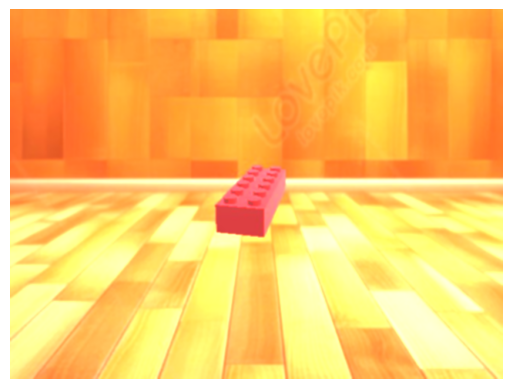

In [5]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def custom_preprocessing(image):
    # Convert tensor to numpy array
    image = tf.keras.preprocessing.image.img_to_array(image)

    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Adjust brightness and contrast
    alpha = 1.5  # Contrast control (1.0-3.0)
    beta = 30    # Brightness control (0-100)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Convert back to tensor
    image = tf.convert_to_tensor(image)

    return image



# Load an image
image_path = 'C:\\Users\\romy.bouabdo\\Desktop\\Romy\\self_driving_car\\relu\\data\\lego_unity.jpg'
image = tf.keras.preprocessing.image.load_img(image_path)

# Preprocess the image
image = custom_preprocessing(image)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()